# Finish open rail analysis

In [2]:
import json
import os
import pandas as pd
import re
import seaborn as sns
import pyarrow.feather as feather

In [30]:
# Useful function
def underscore_lower_match(match):
    return '_'+match.group(1).lower()

def cURL(url, *options):
    '''Function will call curl on the system. 
    
    Parameters:
    url: <string> URL to be called by cURL
    *options: <string> optional arguments passed to cURL-call
    
    Returns: 
    os.system call (cURL command)
    '''    
    opt_string = str() #init string and concatenate all optinal arguments, seperator: whitespace
    for i, val in enumerate(options):
        opt_string += f'{val} '
    # Call cURL command on system using concatenated string and url-string
    return os.system(f'curl ' + opt_string + f'{url}')

def mod_file_extension(file, extension='.gz'):
    '''Function will replace the file's extension.
    
    Parameters:
    file: <string> file name together with potential directory path
    extension: <string> new file name extension (incl. dot) to be used. Default: ".gz"
    
    Returns:
    os.system call (mv file)
    '''
    split_string = file.split(sep='.') # splitting file name at ".", which exclusively
    output_file = split_string[0]+extension
    return os.system(f'mv {file} {output_file}')

def decompress_gz(file, extension='.json'):
    '''Function decompresses archive and returns file path.
    
    Parameters:
    file: <string> File to decompress
    extension: <string> File extension (incl. dot) for decompressed file. Default: '.json'
    
    Returns:
    <string> path and name of output file (composed of passed file and extension)
    '''
    split_string = file.split('.')
    output_file = split_string[0]+extension
    os.system(f'gzip -d -c {file} > {output_file}')
    return output_file

def delete_file(file):
    '''
    '''
    return os.system(f'rm {file}')

def tweak_wagons(data_raw):
    '''Function partially flattens input file (json format) and customizes columns, see comments
    
    Parameters:
    data_raw <json object> Data to process
    
    Returns: 
    <pandas DataFrame> DataFrame with one column per wagon, columns as specified below.
    '''
    df = (pd.json_normalize(data_raw, record_path=['journeySections', 'wagons'], # DataFrame with as many rows as "wagons"
        meta=['trainNumber', # Add train number to DataFrame
              'operatorShortCode', # Add short code of train operator to DataFrame
              'trainCategory', # Add train category (such that "IC") to DataFrame
              'trainType', # Add train type to DataFrame
              'departureDate', # Add departure date to DataFrame
              ['journeySection', 'totalLength'], # Add total length of train to DataFrame
              ['journeySection', 'maximumSpeed'], # Add total speed column
              ['journeySection', 'beginTimeTableRow', 'stationShortCode'], # Add station code of begin station
              ['journeySection', 'endTimeTableRow', 'stationShortCode']], # Add station code of end station
        sep='_') # use "_" to concatenate column names, when made up from several contributions (depth > 1)
         )
    df = (df
        .rename(axis='columns', 
                mapper={
                    'journeySection_beginTimeTableRow_stationShortCode': 'departureStationCode',
                    'journeySection_endTimeTableRow_stationShortCode': 'arrivalStationCode'
                })
        .rename(axis='columns', mapper=lambda s: s.split('_')[-1]) # keep only clumn description of deepest level
        # split all column names at capital letters and concatenate lower cased parts with "_"        
        .rename(axis='columns', mapper=lambda s: re.sub(r'([A-Z])', underscore_lower_match, s).lower())
        .rename(axis='columns', mapper={'length': 'length_cm'})
        )
    # If data is without these columns, create them
    if not ('luggage' in df.columns):
        df = df.assign(luggage=pd.Series(index=df.index, dtype='bool', data=False))
    if not ('playground' in df.columns):
        df = df.assign(playground=pd.Series(index=df.index, dtype='bool', data=False))
    if not ('video' in df.columns):
        df = df.assign(video=pd.Series(index=df.index, dtype='bool', data=False))
    if not ('disabled' in df.columns):
        df = df.assign(disabled=pd.Series(index=df.index, dtype='bool', data=False))
    if not ('catering' in df.columns):
        df = df.assign(catering=pd.Series(index=df.index, dtype='bool', data=False))
    if not ('pet' in df.columns):
        df = df.assign(pet=pd.Series(index=df.index, dtype='bool', data=False))
    if not ('vehicle_number' in df.columns):
        df = df.assign(vehicle_number=pd.Series(index=df.index, dtype='string', data='unknown'))
    return (df
        .assign(
            # For following bool columns, missing value means "False"
            playground=lambda s: s.playground.fillna(value=False),
            video=lambda s: s.video.fillna(value=False),
            disabled=lambda s: s.disabled.fillna(value=False), 
            catering=lambda s: s.catering.fillna(value=False),
            pet=lambda s: s.pet.fillna(value=False),
            luggage=lambda s: s.luggage.fillna(value=False),
            # Fill missing values of wagon type with "unknow" > 40% missing values, > 20 diff. wagons
            wagon_type=lambda s: s.wagon_type.fillna(value='unknown')
                .astype('category'),
            # Fill missing values of vehicle number with "unknown"
            vehicle_number=lambda s: s.vehicle_number.fillna('unknown')
        )
        .astype({'location': 'int32',
                 'sales_number': 'int32',
                 'length_cm': 'int32',
                 'departure_date': 'datetime64',
                 'train_number': 'int64',
                 'operator_short_code': 'category',
                 'train_category': 'category',
                 'train_type': 'category',
                 'total_length': 'int32',
                 'maximum_speed': 'int32'
                })
        .sort_index(axis='columns')
)

def wagon_list(json_file):
    '''Function takes one file, opens it and returns pandas DataFrame as specified in "tweak_wagons"
    
    Parameters:
    json_file: <string> File path together with file name. File to process
    
    Returns:
    <pandas DataFrame> DataFrame as specified in function "tweak_wagons" 
    '''
    with open(json_file) as data:
        return tweak_wagons(json.load(data))
    
def collect_compositions_of_day(date='2015-12-11', 
                                working_dir='/home/felbus/ml_for_physicists/temp/'):
    '''Function collects composition information from API of "rata.digitraffic.fi" of specific day
    
    Parameters:
    date <string> Date to collect data of "yyyy-mm-dd"
    working_dir <string> Directory to temporarly store downloaded data in
    '''
    # compose url and file name information for call of cURL 
    url_compositions = 'https://rata.digitraffic.fi/api/v1/compositions/'
    url = url_compositions + date
    file_name = 'temp.gz'
    data_dir = working_dir + file_name
    # Call cURL
    cURL(url, '-H \'Accept-Encoding: gzip\'', '-o', data_dir)
    # Downloaded file is an archive, thus decompress it
    file_decompressed = decompress_gz(data_dir)
    # Turn data into DataFrame, that lists every wagon one time
    df = wagon_list(file_decompressed)
    # Delete temporary files
    delete_file(data_dir)
    delete_file(file_decompressed)
    # Return DataFrame holding every wagon
    return df

def dates_between(date_begin, date_end):
    '''Generator function that returns strings of dates.
    
    Parameters: 
    date_begin <string> First date in generator "yyyy-mm-dd"
    date_end <string> Date to end generator, caution this date is exclusive! "yyyy-mm-dd"
    
    Returns:
    Generator providing dates as strings "yyyy-mm-dd"
    '''
    date = pd.to_datetime(date_begin)
    date_stop = pd.to_datetime(date_end)
    while date < date_stop:
        yield str(date.year)+'-'+f'{date.month:02d}'+'-'+f'{date.day:02d}'
        date += pd.Timedelta(days=1)

def wagon_list_to_total_length(wagons, groupby='train_category'):
    '''Function transforms DataFrame by grouping by "departure date" and aggregate. Returned DataFrame will
    hold cummulative length of wagons in meters.
    
    Parameters:
    wagons <pandas DataFrame> DataFrame that holds at least columns "departure_date", "length_cm" and
    aggregate
    aggregate <string> Column of "wagons" to groupby
    
    Returns:
    <pandas DataFrame> index = dates, columns = groupby of groupby-parameter
    '''
    return (wagons
            .assign(length_cm=lambda s: s.length_cm/100,
                   dayofweek=lambda s: s.departure_date.dt.dayofweek)
            .groupby(['departure_date', groupby, ])
            .length_cm.sum()
            .unstack()
            .resample('M')
            .mean()
            .rename(axis='columns', mapper=lambda s: s.lower())
            .rename(axis='columns', mapper=lambda s:s.replace('-', '_'))
            .reset_index()
            .melt(id_vars=['departure_date'],
                  value_vars=['commuter', 'long_distance'], 
                  value_name='total_length_m')
           )

def collect_total_length(date_begin, date_end):
    '''Function collects information about total length of train compositions for every date specified.
    
    Parameters:
    date_begin <string> First date to collect data for "yyyy-mm-dd"
    date_end <string> Last date (exclusive) to collect data for "yyyy-mm-dd"
    
    Returns:
    <pandas DataFrame> Index: dates, Columns: train_categories, Values: total length [m]
    '''
    df = pd.DataFrame()
    for dates in dates_between(date_begin, date_end):
        df_wagons = collect_compositions_of_day(date=dates)
        df = pd.concat([df, wagon_list_to_total_length(df_wagons)])
    return df

def collect_wagon_list_period(date_begin, date_end):
    '''Function collects information about train compositions for every date specified.
    
    Parameters:
    date_begin <string> First date to collect data for "yyyy-mm-dd"
    date_end <string> Last date (exclusive) to collect data for "yyyy-mm-dd"
    
    Returns:
    <pandas DataFrame> Index: dates, Columns: train_categories, Values: total length [m]
    '''
    df = pd.DataFrame()
    for dates in dates_between(date_begin, date_end):
        df_wagons = collect_compositions_of_day(date=dates)
        df = pd.concat([df, df_wagons], ignore_index=True)
    return df

def save_to_feather(df, file):
    '''Function saves DataFrame to feather file, resetting index first. Avoids problem with DateTime-Index.
    
    Parameters:
    df <pandas DataFrame> DataFrame to save
    file <string> File to save to
    
    Return:
    None
    '''
    df.reset_index().to_feather(file)
    return None
    
def load_from_feather(file):
    '''Function laods pandas DataFrame from feather file. Expects column "departure_date" and will set it
    as index.
    
    Parameters:
    file <string> file (path+name) to load from
    
    Returns:
    <pandas DataFrame> with column "departure_date" set as index
    '''
    df = pd.read_feather(file).set_index('departure_date')
    return df

In [5]:
# Load all train compositions of a specific day

# Define URL for cURL GET 
url_compositions = 'https://rata.digitraffic.fi/api/v1/compositions/'
date = '2020-05-12'
# Define directory and file name to store received data
data_directory = '/home/felbus/ml_for_physicists/temp/'
file_name = 'test.gz'

# Send cURL GET and decompressed received data.
cURL(url_compositions+date, '-H \'Accept-Encoding: gzip\'', '-o', data_directory+file_name)
file_decompressed = decompress_gz(data_directory+file_name)

# Turn data into DataFrame, that lists every wagon one time.
with open(file_decompressed) as data:
    df_wagons = tweak_wagons(json.load(data))
df_wagons.head(2)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26330    0 26330    0     0  68545      0 --:--:-- --:--:-- --:--:-- 68746


arrival_station_code  catering departure_date departure_station_code  \
0                  JNS     False     2020-05-12                    HKI   
1                  JNS     False     2020-05-12                    HKI   

   disabled  length_cm  location  luggage  maximum_speed operator_short_code  \
0     False       2640         2    False            200                  vr   
1      True       2640         3    False            200                  vr   

     pet  playground  sales_number  total_length train_category  train_number  \
0  False       False             5           125  Long-distance             1   
1  False        True             4           125  Long-distance             1   

  train_type vehicle_number  video wagon_type  
0         IC        unknown  False         Ed  
1         IC        unknown  False        Eds

In [3]:
# Create list of all compositions in given period
df_wagon_list = collect_wagon_list_period('2015-12-11', '2023-09-01')
# Store it
df_wagon_list.to_feather('/home/felbus/ml_for_physicists/data/wagon_list2.fea')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33500    0 33500    0     0  97227      0 --:--:-- --:--:-- --:--:-- 97101
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25448    0 25448    0     0  86930      0 --:--:-- --:--:-- --:--:-- 87150
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22707    0 22707    0     0  76479      0 --:--:-- --:--:-- --:--:-- 76454
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33454    0 33454    0     0   100k      0 --:--:-- --:--:-- --:--:--  100k
  % Total    % Received % Xferd  Average Speed   Tim

100 34656    0 34656    0     0   104k      0 --:--:-- --:--:-- --:--:--  104k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34503    0 34503    0     0   101k      0 --:--:-- --:--:-- --:--:--  101k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26919    0 26919    0     0  81629      0 --:--:-- --:--:-- --:--:-- 81820
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23320    0 23320    0     0  78510      0 --:--:-- --:--:-- --:--:-- 78783
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34832    0 34832    0     0   103k      0 --:--:

100 35421    0 35421    0     0   108k      0 --:--:-- --:--:-- --:--:--  108k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35013    0 35013    0     0   105k      0 --:--:-- --:--:-- --:--:--  105k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 27433    0 27433    0     0  87154      0 --:--:-- --:--:-- --:--:-- 87366
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23461    0 23461    0     0  81205      0 --:--:-- --:--:-- --:--:-- 81461
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35340    0 35340    0     0   112k      0 --:--:

100 36282    0 36282    0     0   110k      0 --:--:-- --:--:-- --:--:--  111k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25562    0 25562    0     0  89025      0 --:--:-- --:--:-- --:--:-- 89066
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28052    0 28052    0     0  86241      0 --:--:-- --:--:-- --:--:-- 86049
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23007    0 23007    0     0  77318      0 --:--:-- --:--:-- --:--:-- 77464
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23588    0 23588    0     0  87170      0 --:--:

100 34149    0 34149    0     0   106k      0 --:--:-- --:--:-- --:--:--  106k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33796    0 33796    0     0   108k      0 --:--:-- --:--:-- --:--:--  108k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25938    0 25938    0     0  85133      0 --:--:-- --:--:-- --:--:-- 85042
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24046    0 24046    0     0  83053      0 --:--:-- --:--:-- --:--:-- 83204
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33473    0 33473    0     0    98k      0 --:--:

100 34234    0 34234    0     0   102k      0 --:--:-- --:--:-- --:--:--  102k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34286    0 34286    0     0   100k      0 --:--:-- --:--:-- --:--:--  100k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25774    0 25774    0     0  89624      0 --:--:-- --:--:-- --:--:-- 89493
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22807    0 22807    0     0  80815      0 --:--:-- --:--:-- --:--:-- 80875
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34484    0 34484    0     0    97k      0 --:--:

100 33305    0 33305    0     0  94266      0 --:--:-- --:--:-- --:--:-- 94348
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33824    0 33824    0     0   100k      0 --:--:-- --:--:-- --:--:--  100k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26847    0 26847    0     0  85838      0 --:--:-- --:--:-- --:--:-- 86048
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24115    0 24115    0     0  79505      0 --:--:-- --:--:-- --:--:-- 79325
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33797    0 33797    0     0  88117      0 --:--:

100 33669    0 33669    0     0   104k      0 --:--:-- --:--:-- --:--:--  105k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34207    0 34207    0     0   105k      0 --:--:-- --:--:-- --:--:--  105k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26044    0 26044    0     0  74247      0 --:--:-- --:--:-- --:--:-- 74411
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23669    0 23669    0     0  85279      0 --:--:-- --:--:-- --:--:-- 85140
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34699    0 34699    0     0   111k      0 --:--:

100 34167    0 34167    0     0   104k      0 --:--:-- --:--:-- --:--:--  104k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34867    0 34867    0     0   109k      0 --:--:-- --:--:-- --:--:--  109k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26125    0 26125    0     0  81809      0 --:--:-- --:--:-- --:--:-- 81896
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22853    0 22853    0     0  77587      0 --:--:-- --:--:-- --:--:-- 77731
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33552    0 33552    0     0   100k      0 --:--:

100 35199    0 35199    0     0   107k      0 --:--:-- --:--:-- --:--:--  107k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 36094    0 36094    0     0   109k      0 --:--:-- --:--:-- --:--:--  109k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26935    0 26935    0     0  87181      0 --:--:-- --:--:-- --:--:-- 87451
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23948    0 23948    0     0  83847      0 --:--:-- --:--:-- --:--:-- 83734
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34699    0 34699    0     0   109k      0 --:--:

100 34465    0 34465    0     0   107k      0 --:--:-- --:--:-- --:--:--  107k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34694    0 34694    0     0   102k      0 --:--:-- --:--:-- --:--:--  102k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26091    0 26091    0     0  84334      0 --:--:-- --:--:-- --:--:-- 84164
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22868    0 22868    0     0  80299      0 --:--:-- --:--:-- --:--:-- 80521
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 32332    0 32332    0     0   101k      0 --:--:

100 35519    0 35519    0     0   106k      0 --:--:-- --:--:-- --:--:--  106k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34838    0 34838    0     0   108k      0 --:--:-- --:--:-- --:--:--  108k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25755    0 25755    0     0  85342      0 --:--:-- --:--:-- --:--:-- 85564
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24818    0 24818    0     0  87355      0 --:--:-- --:--:-- --:--:-- 87080
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35686    0 35686    0     0   111k      0 --:--:

100 34731    0 34731    0     0   100k      0 --:--:-- --:--:-- --:--:--  100k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35593    0 35593    0     0   102k      0 --:--:-- --:--:-- --:--:--  102k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26224    0 26224    0     0  83725      0 --:--:-- --:--:-- --:--:-- 83782
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23451    0 23451    0     0  83342      0 --:--:-- --:--:-- --:--:-- 83159
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35024    0 35024    0     0   106k      0 --:--:

100 33765    0 33765    0     0   103k      0 --:--:-- --:--:-- --:--:--  103k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35141    0 35141    0     0   107k      0 --:--:-- --:--:-- --:--:--  107k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25997    0 25997    0     0  80119      0 --:--:-- --:--:-- --:--:-- 79990
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22990    0 22990    0     0  82603      0 --:--:-- --:--:-- --:--:-- 82697
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33256    0 33256    0     0    98k      0 --:--:

100 34643    0 34643    0     0   105k      0 --:--:-- --:--:-- --:--:--  105k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23219    0 23219    0     0  84795      0 --:--:-- --:--:-- --:--:-- 84740
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25383    0 25383    0     0  88156      0 --:--:-- --:--:-- --:--:-- 88442
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22025    0 22025    0     0  77351      0 --:--:-- --:--:-- --:--:-- 77280
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23648    0 23648    0     0  84687      0 --:--:

100 32604    0 32604    0     0   102k      0 --:--:-- --:--:-- --:--:--  102k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 32708    0 32708    0     0   101k      0 --:--:-- --:--:-- --:--:--  101k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24366    0 24366    0     0  86522      0 --:--:-- --:--:-- --:--:-- 86404
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22597    0 22597    0     0  82854      0 --:--:-- --:--:-- --:--:-- 83077
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33045    0 33045    0     0  99964      0 --:--:

100 34136    0 34136    0     0  94083      0 --:--:-- --:--:-- --:--:-- 94038
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22679    0 22679    0     0  78214      0 --:--:-- --:--:-- --:--:-- 78474
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16544    0 16544    0     0  61083      0 --:--:-- --:--:-- --:--:-- 61274
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22112    0 22112    0     0  81650      0 --:--:-- --:--:-- --:--:-- 81896
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 32048    0 32048    0     0  95936      0 --:--:

100 31978    0 31978    0     0  97487      0 --:--:-- --:--:-- --:--:-- 97792
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 32566    0 32566    0     0   101k      0 --:--:-- --:--:-- --:--:--  101k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25179    0 25179    0     0  85126      0 --:--:-- --:--:-- --:--:-- 85352
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22780    0 22780    0     0  82095      0 --:--:-- --:--:-- --:--:-- 81942
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 32159    0 32159    0     0  99329      0 --:--:

100 33069    0 33069    0     0  94589      0 --:--:-- --:--:-- --:--:-- 94482
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33397    0 33397    0     0  94741      0 --:--:-- --:--:-- --:--:-- 94877
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26179    0 26179    0     0  80044      0 --:--:-- --:--:-- --:--:-- 80058
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23381    0 23381    0     0  74106      0 --:--:-- --:--:-- --:--:-- 74225
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 32365    0 32365    0     0  97659      0 --:--:

100 32674    0 32674    0     0   104k      0 --:--:-- --:--:-- --:--:--  104k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33461    0 33461    0     0    98k      0 --:--:-- --:--:-- --:--:--   98k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26396    0 26396    0     0  84095      0 --:--:-- --:--:-- --:--:-- 84063
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22915    0 22915    0     0  84110      0 --:--:-- --:--:-- --:--:-- 84246
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 32674    0 32674    0     0  97402      0 --:--:

100 33181    0 33181    0     0   102k      0 --:--:-- --:--:-- --:--:--  102k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33757    0 33757    0     0   100k      0 --:--:-- --:--:-- --:--:--  100k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25632    0 25632    0     0  87897      0 --:--:-- --:--:-- --:--:-- 88082
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23079    0 23079    0     0  79986      0 --:--:-- --:--:-- --:--:-- 80135
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 32628    0 32628    0     0  97966      0 --:--:

100 33894    0 33894    0     0    97k      0 --:--:-- --:--:-- --:--:--   97k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33687    0 33687    0     0  98436      0 --:--:-- --:--:-- --:--:-- 98500
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26549    0 26549    0     0  85988      0 --:--:-- --:--:-- --:--:-- 85919
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24068    0 24068    0     0  80807      0 --:--:-- --:--:-- --:--:-- 81037
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33865    0 33865    0     0    97k      0 --:--:

100 33552    0 33552    0     0  99755      0 --:--:-- --:--:-- --:--:-- 99857
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34266    0 34266    0     0   112k      0 --:--:-- --:--:-- --:--:--  113k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26338    0 26338    0     0  80404      0 --:--:-- --:--:-- --:--:-- 80544
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23269    0 23269    0     0  81432      0 --:--:-- --:--:-- --:--:-- 81360
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 32860    0 32860    0     0   100k      0 --:--:

100 34345    0 34345    0     0    98k      0 --:--:-- --:--:-- --:--:--   98k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35145    0 35145    0     0   108k      0 --:--:-- --:--:-- --:--:--  108k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26974    0 26974    0     0  87609      0 --:--:-- --:--:-- --:--:-- 87863
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24344    0 24344    0     0  84411      0 --:--:-- --:--:-- --:--:-- 84235
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34019    0 34019    0     0   102k      0 --:--:

100 35041    0 35041    0     0   103k      0 --:--:-- --:--:-- --:--:--  103k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24959    0 24959    0     0  89611      0 --:--:-- --:--:-- --:--:-- 89780
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 27156    0 27156    0     0  85220      0 --:--:-- --:--:-- --:--:-- 85396
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23467    0 23467    0     0  85717      0 --:--:-- --:--:-- --:--:-- 85645
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24651    0 24651    0     0  87289      0 --:--:

100 33415    0 33415    0     0   107k      0 --:--:-- --:--:-- --:--:--  107k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33543    0 33543    0     0   106k      0 --:--:-- --:--:-- --:--:--  106k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25817    0 25817    0     0  90847      0 --:--:-- --:--:-- --:--:-- 90904
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24174    0 24174    0     0  86025      0 --:--:-- --:--:-- --:--:-- 86028
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33600    0 33600    0     0  97511      0 --:--:

100 34337    0 34337    0     0   106k      0 --:--:-- --:--:-- --:--:--  107k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34829    0 34829    0     0   101k      0 --:--:-- --:--:-- --:--:--  101k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26763    0 26763    0     0  88078      0 --:--:-- --:--:-- --:--:-- 88326
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22225    0 22225    0     0  78085      0 --:--:-- --:--:-- --:--:-- 78257
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31797    0 31797    0     0  96138      0 --:--:

100 34647    0 34647    0     0   104k      0 --:--:-- --:--:-- --:--:--  105k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34537    0 34537    0     0   106k      0 --:--:-- --:--:-- --:--:--  106k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28782    0 28782    0     0  88642      0 --:--:-- --:--:-- --:--:-- 88833
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25949    0 25949    0     0  82711      0 --:--:-- --:--:-- --:--:-- 82904
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35297    0 35297    0     0   108k      0 --:--:

100 33579    0 33579    0     0   100k      0 --:--:-- --:--:-- --:--:--  100k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33912    0 33912    0     0    99k      0 --:--:-- --:--:-- --:--:--   99k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 27076    0 27076    0     0  85872      0 --:--:-- --:--:-- --:--:-- 85955
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24615    0 24615    0     0  90009      0 --:--:-- --:--:-- --:--:-- 90164
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34243    0 34243    0     0   100k      0 --:--:

100 34700    0 34700    0     0    99k      0 --:--:-- --:--:-- --:--:--   98k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35223    0 35223    0     0   100k      0 --:--:-- --:--:-- --:--:--  100k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 27260    0 27260    0     0  84733      0 --:--:-- --:--:-- --:--:-- 84922
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25168    0 25168    0     0  85093      0 --:--:-- --:--:-- --:--:-- 85027
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34843    0 34843    0     0   102k      0 --:--:

100 34342    0 34342    0     0   107k      0 --:--:-- --:--:-- --:--:--  107k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34527    0 34527    0     0   101k      0 --:--:-- --:--:-- --:--:--  101k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 27125    0 27125    0     0  91261      0 --:--:-- --:--:-- --:--:-- 91329
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24734    0 24734    0     0  85667      0 --:--:-- --:--:-- --:--:-- 85584
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34553    0 34553    0     0   100k      0 --:--:

100 35026    0 35026    0     0   102k      0 --:--:-- --:--:-- --:--:--  103k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35111    0 35111    0     0   107k      0 --:--:-- --:--:-- --:--:--  107k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26164    0 26164    0     0  83581      0 --:--:-- --:--:-- --:--:-- 83591
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24722    0 24722    0     0  85404      0 --:--:-- --:--:-- --:--:-- 85543
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34233    0 34233    0     0   102k      0 --:--:

100 35624    0 35624    0     0   109k      0 --:--:-- --:--:-- --:--:--  109k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35830    0 35830    0     0   103k      0 --:--:-- --:--:-- --:--:--  102k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28024    0 28024    0     0  88093      0 --:--:-- --:--:-- --:--:-- 88125
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25058    0 25058    0     0  92637      0 --:--:-- --:--:-- --:--:-- 92807
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35098    0 35098    0     0   107k      0 --:--:

100 34418    0 34418    0     0   104k      0 --:--:-- --:--:-- --:--:--  104k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34803    0 34803    0     0   108k      0 --:--:-- --:--:-- --:--:--  108k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28028    0 28028    0     0  88574      0 --:--:-- --:--:-- --:--:-- 88696
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25027    0 25027    0     0  91052      0 --:--:-- --:--:-- --:--:-- 91007
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33748    0 33748    0     0   101k      0 --:--:

100 34843    0 34843    0     0   106k      0 --:--:-- --:--:-- --:--:--  106k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 36071    0 36071    0     0   102k      0 --:--:-- --:--:-- --:--:--  102k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 27785    0 27785    0     0  87395      0 --:--:-- --:--:-- --:--:-- 87374
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24985    0 24985    0     0  85117      0 --:--:-- --:--:-- --:--:-- 85273
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35186    0 35186    0     0   106k      0 --:--:

100 36450    0 36450    0     0   109k      0 --:--:-- --:--:-- --:--:--  109k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 27390    0 27390    0     0  84768      0 --:--:-- --:--:-- --:--:-- 84798
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28582    0 28582    0     0  92146      0 --:--:-- --:--:-- --:--:-- 91903
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24442    0 24442    0     0  88306      0 --:--:-- --:--:-- --:--:-- 88557
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25798    0 25798    0     0  89962      0 --:--:

100 34604    0 34604    0     0   104k      0 --:--:-- --:--:-- --:--:--  104k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34759    0 34759    0     0   108k      0 --:--:-- --:--:-- --:--:--  108k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 27978    0 27978    0     0  85468      0 --:--:-- --:--:-- --:--:-- 85298
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24788    0 24788    0     0  86041      0 --:--:-- --:--:-- --:--:-- 86069
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34756    0 34756    0     0   107k      0 --:--:

100 32125    0 32125    0     0  93443      0 --:--:-- --:--:-- --:--:-- 93658
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33239    0 33239    0     0   100k      0 --:--:-- --:--:-- --:--:--  100k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28504    0 28504    0     0  89003      0 --:--:-- --:--:-- --:--:-- 88797
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25298    0 25298    0     0  81592      0 --:--:-- --:--:-- --:--:-- 81870
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33719    0 33719    0     0  96829      0 --:--:

100 33988    0 33988    0     0   109k      0 --:--:-- --:--:-- --:--:--  109k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34107    0 34107    0     0   104k      0 --:--:-- --:--:-- --:--:--  104k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26317    0 26317    0     0  84310      0 --:--:-- --:--:-- --:--:-- 84349
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24743    0 24743    0     0  87372      0 --:--:-- --:--:-- --:--:-- 87431
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33702    0 33702    0     0  99904      0 --:--:

100 34730    0 34730    0     0    99k      0 --:--:-- --:--:-- --:--:--  100k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34722    0 34722    0     0   110k      0 --:--:-- --:--:-- --:--:--  110k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 27609    0 27609    0     0  97672      0 --:--:-- --:--:-- --:--:-- 97904
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25226    0 25226    0     0  91340      0 --:--:-- --:--:-- --:--:-- 91398
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34359    0 34359    0     0   108k      0 --:--:

100 34284    0 34284    0     0   103k      0 --:--:-- --:--:-- --:--:--  103k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34999    0 34999    0     0   103k      0 --:--:-- --:--:-- --:--:--  103k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 27218    0 27218    0     0  90671      0 --:--:-- --:--:-- --:--:-- 90425
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25032    0 25032    0     0  86678      0 --:--:-- --:--:-- --:--:-- 86916
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34091    0 34091    0     0   106k      0 --:--:

100 35006    0 35006    0     0   101k      0 --:--:-- --:--:-- --:--:--  101k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34531    0 34531    0     0   101k      0 --:--:-- --:--:-- --:--:--  101k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25616    0 25616    0     0  91989      0 --:--:-- --:--:-- --:--:-- 92143
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23534    0 23534    0     0  78008      0 --:--:-- --:--:-- --:--:-- 78186
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34633    0 34633    0     0   101k      0 --:--:

100 36945    0 36945    0     0   115k      0 --:--:-- --:--:-- --:--:--  115k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 37198    0 37198    0     0   113k      0 --:--:-- --:--:-- --:--:--  113k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29022    0 29022    0     0  99145      0 --:--:-- --:--:-- --:--:-- 99390
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26514    0 26514    0     0  86094      0 --:--:-- --:--:-- --:--:-- 86084
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35234    0 35234    0     0   104k      0 --:--:

100 34815    0 34815    0     0    99k      0 --:--:-- --:--:-- --:--:--   99k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35636    0 35636    0     0   102k      0 --:--:-- --:--:-- --:--:--  102k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28185    0 28185    0     0  88867      0 --:--:-- --:--:-- --:--:-- 88911
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25425    0 25425    0     0  87171      0 --:--:-- --:--:-- --:--:-- 87371
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34940    0 34940    0     0   106k      0 --:--:

100 35268    0 35268    0     0   106k      0 --:--:-- --:--:-- --:--:--  106k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 36369    0 36369    0     0   109k      0 --:--:-- --:--:-- --:--:--  109k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28921    0 28921    0     0  91551      0 --:--:-- --:--:-- --:--:-- 91812
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25448    0 25448    0     0  87932      0 --:--:-- --:--:-- --:--:-- 88055
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34541    0 34541    0     0  97933      0 --:--:

100 32419    0 32419    0     0  99052      0 --:--:-- --:--:-- --:--:-- 99140
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 32989    0 32989    0     0   103k      0 --:--:-- --:--:-- --:--:--  103k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25645    0 25645    0     0  86628      0 --:--:-- --:--:-- --:--:-- 86638
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23144    0 23144    0     0  81888      0 --:--:-- --:--:-- --:--:-- 82070
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 32427    0 32427    0     0  95083      0 --:--:

100 27762    0 27762    0     0  90576      0 --:--:-- --:--:-- --:--:-- 90725
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26991    0 26991    0     0  94218      0 --:--:-- --:--:-- --:--:-- 94374
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 21460    0 21460    0     0  73655      0 --:--:-- --:--:-- --:--:-- 73493
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18088    0 18088    0     0  66347      0 --:--:-- --:--:-- --:--:-- 66500
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26410    0 26410    0     0  80263      0 --:--:

100 35824    0 35824    0     0   112k      0 --:--:-- --:--:-- --:--:--  112k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35410    0 35410    0     0   109k      0 --:--:-- --:--:-- --:--:--  109k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26541    0 26541    0     0  84370      0 --:--:-- --:--:-- --:--:-- 84525
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22848    0 22848    0     0  77198      0 --:--:-- --:--:-- --:--:-- 77450
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35263    0 35263    0     0   106k      0 --:--:

100 34610    0 34610    0     0   107k      0 --:--:-- --:--:-- --:--:--  107k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35401    0 35401    0     0   102k      0 --:--:-- --:--:-- --:--:--  103k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28062    0 28062    0     0    99k      0 --:--:-- --:--:-- --:--:--   99k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23953    0 23953    0     0  88040      0 --:--:-- --:--:-- --:--:-- 88387
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35038    0 35038    0     0   107k      0 --:--:

100 39686    0 39686    0     0   115k      0 --:--:-- --:--:-- --:--:--  115k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 40888    0 40888    0     0   124k      0 --:--:-- --:--:-- --:--:--  124k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29324    0 29324    0     0  90081      0 --:--:-- --:--:-- --:--:-- 90227
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25034    0 25034    0     0  89291      0 --:--:-- --:--:-- --:--:-- 89407
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 39877    0 39877    0     0   123k      0 --:--:

100 48792    0 48792    0     0   143k      0 --:--:-- --:--:-- --:--:--  143k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 51986    0 51986    0     0   144k      0 --:--:-- --:--:-- --:--:--  144k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 39282    0 39282    0     0   125k      0 --:--:-- --:--:-- --:--:--  124k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33398    0 33398    0     0   100k      0 --:--:-- --:--:-- --:--:--  100k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 51557    0 51557    0     0   139k      0 --:--:

100 51147    0 51147    0     0   134k      0 --:--:-- --:--:-- --:--:--  134k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 51846    0 51846    0     0   139k      0 --:--:-- --:--:-- --:--:--  139k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 37815    0 37815    0     0   112k      0 --:--:-- --:--:-- --:--:--  112k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 32873    0 32873    0     0    99k      0 --:--:-- --:--:-- --:--:--  100k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 51820    0 51820    0     0   129k      0 --:--:

100 51377    0 51377    0     0   135k      0 --:--:-- --:--:-- --:--:--  135k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 52602    0 52602    0     0   148k      0 --:--:-- --:--:-- --:--:--  148k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 39358    0 39358    0     0   123k      0 --:--:-- --:--:-- --:--:--  123k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33350    0 33350    0     0  88383      0 --:--:-- --:--:-- --:--:-- 88461
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 51234    0 51234    0     0   125k      0 --:--:

100 51863    0 51863    0     0   132k      0 --:--:-- --:--:-- --:--:--  132k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 52255    0 52255    0     0   149k      0 --:--:-- --:--:-- --:--:--  149k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 38887    0 38887    0     0   110k      0 --:--:-- --:--:-- --:--:--  110k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33771    0 33771    0     0   105k      0 --:--:-- --:--:-- --:--:--  105k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50212    0 50212    0     0   137k      0 --:--:

100 49826    0 49826    0     0   132k      0 --:--:-- --:--:-- --:--:--  132k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 52308    0 52308    0     0   143k      0 --:--:-- --:--:-- --:--:--  144k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 38295    0 38295    0     0   119k      0 --:--:-- --:--:-- --:--:--  119k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33658    0 33658    0     0  99850      0 --:--:-- --:--:-- --:--:-- 99875
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50514    0 50514    0     0   138k      0 --:--:

100 30401    0 30401    0     0  94899      0 --:--:-- --:--:-- --:--:-- 95003
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 21828    0 21828    0     0  77922      0 --:--:-- --:--:-- --:--:-- 77679
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 36175    0 36175    0     0   109k      0 --:--:-- --:--:-- --:--:--  110k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33124    0 33124    0     0   110k      0 --:--:-- --:--:-- --:--:--  110k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 49895    0 49895    0     0   141k      0 --:--:

100 47944    0 47944    0     0   143k      0 --:--:-- --:--:-- --:--:--  143k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 49802    0 49802    0     0   131k      0 --:--:-- --:--:-- --:--:--  132k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 37014    0 37014    0     0   115k      0 --:--:-- --:--:-- --:--:--  115k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 32880    0 32880    0     0   101k      0 --:--:-- --:--:-- --:--:--  101k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 48361    0 48361    0     0   131k      0 --:--:

100 48318    0 48318    0     0   126k      0 --:--:-- --:--:-- --:--:--  126k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50748    0 50748    0     0   139k      0 --:--:-- --:--:-- --:--:--  139k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 36785    0 36785    0     0   113k      0 --:--:-- --:--:-- --:--:--  113k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 32293    0 32293    0     0  98902      0 --:--:-- --:--:-- --:--:-- 98755
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 48876    0 48876    0     0   152k      0 --:--:

100 44940    0 44940    0     0   121k      0 --:--:-- --:--:-- --:--:--  121k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45453    0 45453    0     0   125k      0 --:--:-- --:--:-- --:--:--  125k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34893    0 34893    0     0   109k      0 --:--:-- --:--:-- --:--:--  109k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 32256    0 32256    0     0  93622      0 --:--:-- --:--:-- --:--:-- 93767
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45154    0 45154    0     0   134k      0 --:--:

100 45088    0 45088    0     0   117k      0 --:--:-- --:--:-- --:--:--  117k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 46440    0 46440    0     0   135k      0 --:--:-- --:--:-- --:--:--  135k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 36786    0 36786    0     0   112k      0 --:--:-- --:--:-- --:--:--  112k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33835    0 33835    0     0   104k      0 --:--:-- --:--:-- --:--:--  104k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44221    0 44221    0     0   115k      0 --:--:

100 50414    0 50414    0     0   133k      0 --:--:-- --:--:-- --:--:--  133k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50489    0 50489    0     0   128k      0 --:--:-- --:--:-- --:--:--  128k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 39004    0 39004    0     0   118k      0 --:--:-- --:--:-- --:--:--  118k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34151    0 34151    0     0    98k      0 --:--:-- --:--:-- --:--:--   98k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 49726    0 49726    0     0   139k      0 --:--:

100 49941    0 49941    0     0   136k      0 --:--:-- --:--:-- --:--:--  136k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50933    0 50933    0     0   140k      0 --:--:-- --:--:-- --:--:--  140k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 38868    0 38868    0     0   119k      0 --:--:-- --:--:-- --:--:--  120k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33676    0 33676    0     0   105k      0 --:--:-- --:--:-- --:--:--  106k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50578    0 50578    0     0   140k      0 --:--:

100 49665    0 49665    0     0   141k      0 --:--:-- --:--:-- --:--:--  142k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50884    0 50884    0     0   135k      0 --:--:-- --:--:-- --:--:--  136k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 38470    0 38470    0     0   118k      0 --:--:-- --:--:-- --:--:--  118k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33525    0 33525    0     0   105k      0 --:--:-- --:--:-- --:--:--  105k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 47163    0 47163    0     0   129k      0 --:--:

100 52665    0 52665    0     0   143k      0 --:--:-- --:--:-- --:--:--  143k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26718    0 26718    0     0  91495      0 --:--:-- --:--:-- --:--:-- 91814
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28607    0 28607    0     0    98k      0 --:--:-- --:--:-- --:--:--   98k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35194    0 35194    0     0   109k      0 --:--:-- --:--:-- --:--:--  109k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 52008    0 52008    0     0   144k      0 --:--:

100 49581    0 49581    0     0   142k      0 --:--:-- --:--:-- --:--:--  142k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50974    0 50974    0     0   134k      0 --:--:-- --:--:-- --:--:--  134k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 38806    0 38806    0     0   119k      0 --:--:-- --:--:-- --:--:--  119k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33355    0 33355    0     0    99k      0 --:--:-- --:--:-- --:--:--   99k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50590    0 50590    0     0   132k      0 --:--:

100 49788    0 49788    0     0   136k      0 --:--:-- --:--:-- --:--:--  136k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 51460    0 51460    0     0   138k      0 --:--:-- --:--:-- --:--:--  138k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 38941    0 38941    0     0   115k      0 --:--:-- --:--:-- --:--:--  115k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33069    0 33069    0     0   104k      0 --:--:-- --:--:-- --:--:--  104k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50042    0 50042    0     0   136k      0 --:--:

100 50140    0 50140    0     0   138k      0 --:--:-- --:--:-- --:--:--  139k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 51227    0 51227    0     0   135k      0 --:--:-- --:--:-- --:--:--  135k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 38621    0 38621    0     0   106k      0 --:--:-- --:--:-- --:--:--  106k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33368    0 33368    0     0   105k      0 --:--:-- --:--:-- --:--:--  105k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50103    0 50103    0     0   136k      0 --:--:

100 48787    0 48787    0     0   129k      0 --:--:-- --:--:-- --:--:--  129k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50901    0 50901    0     0   132k      0 --:--:-- --:--:-- --:--:--  132k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 38949    0 38949    0     0   117k      0 --:--:-- --:--:-- --:--:--  117k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34196    0 34196    0     0    98k      0 --:--:-- --:--:-- --:--:--   97k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50751    0 50751    0     0   142k      0 --:--:

100 51364    0 51364    0     0   145k      0 --:--:-- --:--:-- --:--:--  145k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 51334    0 51334    0     0   143k      0 --:--:-- --:--:-- --:--:--  143k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 36975    0 36975    0     0   112k      0 --:--:-- --:--:-- --:--:--  111k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33816    0 33816    0     0   103k      0 --:--:-- --:--:-- --:--:--  103k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 49983    0 49983    0     0   140k      0 --:--:

100 50835    0 50835    0     0   140k      0 --:--:-- --:--:-- --:--:--  140k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 51646    0 51646    0     0   138k      0 --:--:-- --:--:-- --:--:--  137k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 39622    0 39622    0     0   124k      0 --:--:-- --:--:-- --:--:--  124k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34749    0 34749    0     0   105k      0 --:--:-- --:--:-- --:--:--  105k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50776    0 50776    0     0   135k      0 --:--:

100 50067    0 50067    0     0   144k      0 --:--:-- --:--:-- --:--:--  145k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 51700    0 51700    0     0   140k      0 --:--:-- --:--:-- --:--:--  140k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 39521    0 39521    0     0   118k      0 --:--:-- --:--:-- --:--:--  118k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33638    0 33638    0     0   104k      0 --:--:-- --:--:-- --:--:--  103k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50926    0 50926    0     0   142k      0 --:--:

100 51937    0 51937    0     0   140k      0 --:--:-- --:--:-- --:--:--  140k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 52188    0 52188    0     0   138k      0 --:--:-- --:--:-- --:--:--  138k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 40432    0 40432    0     0   114k      0 --:--:-- --:--:-- --:--:--  114k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33635    0 33635    0     0   103k      0 --:--:-- --:--:-- --:--:--  103k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 51026    0 51026    0     0   130k      0 --:--:

100 50676    0 50676    0     0   142k      0 --:--:-- --:--:-- --:--:--  143k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 51529    0 51529    0     0   135k      0 --:--:-- --:--:-- --:--:--  135k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 39365    0 39365    0     0   112k      0 --:--:-- --:--:-- --:--:--  112k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34036    0 34036    0     0   100k      0 --:--:-- --:--:-- --:--:--  100k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 51067    0 51067    0     0   150k      0 --:--:

100 51971    0 51971    0     0   131k      0 --:--:-- --:--:-- --:--:--  131k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 53098    0 53098    0     0   143k      0 --:--:-- --:--:-- --:--:--  144k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 40558    0 40558    0     0   124k      0 --:--:-- --:--:-- --:--:--  124k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34195    0 34195    0     0   105k      0 --:--:-- --:--:-- --:--:--  105k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 48949    0 48949    0     0   148k      0 --:--:

100 49755    0 49755    0     0   142k      0 --:--:-- --:--:-- --:--:--  142k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 51592    0 51592    0     0   136k      0 --:--:-- --:--:-- --:--:--  136k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 37920    0 37920    0     0   113k      0 --:--:-- --:--:-- --:--:--  113k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 32868    0 32868    0     0  98147      0 --:--:-- --:--:-- --:--:-- 98407
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 49559    0 49559    0     0   138k      0 --:--:

100 51052    0 51052    0     0   128k      0 --:--:-- --:--:-- --:--:--  127k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 52264    0 52264    0     0   151k      0 --:--:-- --:--:-- --:--:--  151k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 38767    0 38767    0     0   113k      0 --:--:-- --:--:-- --:--:--  113k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34363    0 34363    0     0   102k      0 --:--:-- --:--:-- --:--:--  102k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 51045    0 51045    0     0  90955      0 --:--:

100  1912    0  1912    0     0   8248      0 --:--:-- --:--:-- --:--:--  8277
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 51034    0 51034    0     0   141k      0 --:--:-- --:--:-- --:--:--  141k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 39583    0 39583    0     0   114k      0 --:--:-- --:--:-- --:--:--  114k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34274    0 34274    0     0   103k      0 --:--:-- --:--:-- --:--:--  103k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50637    0 50637    0     0   144k      0 --:--:

100 50591    0 50591    0     0   134k      0 --:--:-- --:--:-- --:--:--  134k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 51239    0 51239    0     0   126k      0 --:--:-- --:--:-- --:--:--  127k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 38913    0 38913    0     0   122k      0 --:--:-- --:--:-- --:--:--  122k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33913    0 33913    0     0   102k      0 --:--:-- --:--:-- --:--:--  102k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 36922    0 36922    0     0   112k      0 --:--:

100 47545    0 47545    0     0   124k      0 --:--:-- --:--:-- --:--:--  125k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 48111    0 48111    0     0   137k      0 --:--:-- --:--:-- --:--:--  137k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 38180    0 38180    0     0   116k      0 --:--:-- --:--:-- --:--:--  116k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33995    0 33995    0     0   106k      0 --:--:-- --:--:-- --:--:--  106k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 46975    0 46975    0     0   146k      0 --:--:

100 48049    0 48049    0     0   142k      0 --:--:-- --:--:-- --:--:--  142k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 48632    0 48632    0     0   131k      0 --:--:-- --:--:-- --:--:--  131k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 38713    0 38713    0     0   119k      0 --:--:-- --:--:-- --:--:--  119k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34081    0 34081    0     0   102k      0 --:--:-- --:--:-- --:--:--  102k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 47307    0 47307    0     0   124k      0 --:--:

100 47496    0 47496    0     0   127k      0 --:--:-- --:--:-- --:--:--  127k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 48293    0 48293    0     0   143k      0 --:--:-- --:--:-- --:--:--  143k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 39453    0 39453    0     0   122k      0 --:--:-- --:--:-- --:--:--  123k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35395    0 35395    0     0   110k      0 --:--:-- --:--:-- --:--:--  111k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 46837    0 46837    0     0   125k      0 --:--:

In [4]:
# Load data of compositions
df = pd.read_feather('/home/felbus/ml_for_physicists/data/wagon_list.fea')

## Exploratory data analysis

In [5]:
# Any missing values left
print(f'Any missing data in DataFrame? {df.isna().any().any()}')

Any missing data in DataFrame? False


/home/felbus/ml_for_physicists/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


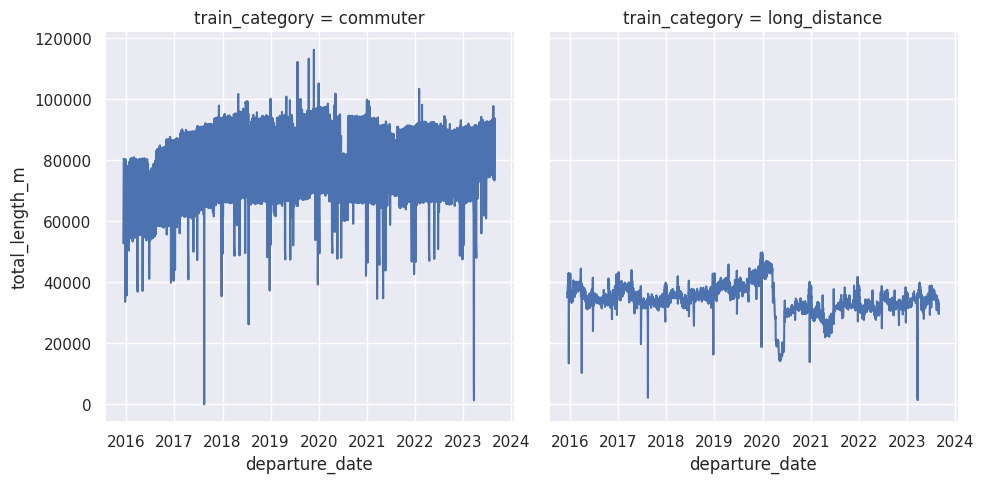

In [31]:
# Plotting time series of total train length with seaborn
sns.set_theme() #set default theme

sns.relplot(data=wagon_list_to_total_length(df), x='departure_date', 
            y='total_length_m', col='train_category', kind='line')

In [72]:
(df
 .assign(length_cm=lambda s: s.length_cm/100,
          dayofweek=lambda s: s.departure_date.dt.dayofweek)
 .rename(axis='columns', mapper=lambda s: s.lower())
 .rename(axis='columns', mapper=lambda s:s.replace('-', '_'))
 .groupby(['departure_date', 'train_category', 'dayofweek'])
 .length_cm.sum()
 .unstack() # pull out dayofweek as columns
 .unstack()
 .reset_index()
 .set_index('departure_date')
 .resample('M')
 .mean()

 .melt()
)

dayofweek train_category         value
0            0       Commuter  80213.066667
1            0       Commuter  77004.450000
2            0       Commuter  79618.320000
3            0       Commuter  69410.100000
4            0       Commuter  79938.600000
...        ...            ...           ...
1297         6  Long-distance  30808.448000
1298         6  Long-distance  30515.530000
1299         6  Long-distance  31629.375000
1300         6  Long-distance  32331.572000
1301         6  Long-distance  32319.240000

[1302 rows x 3 columns]

In [33]:
df.departure_date.dt.dayofweek

0          4
1          4
2          4
3          4
4          4
          ..
6777389    3
6777390    3
6777391    3
6777392    3
6777393    3
Name: departure_date, Length: 6777394, dtype: int64

In [45]:
df_wagons.groupby(['departure_date', 'train_category']).length_cm.sum().unstack()

train_category  Commuter  Long-distance
departure_date                         
2019-04-12       9477200        4383054

In [40]:
df_wagons.groupby(['departure_date', 'train_category']).length_cm.sum().unstack().reset_index().to_feather('test.fea')

In [56]:
date = pd.to_datetime('2015-12-12')
print(date, '\n')
date_next = date + pd.Timedelta(days=1)
print(date_next)


2015-12-12 00:00:00 

2015-12-13 00:00:00


In [59]:
def infinite_sequence():
    date = pd.to_datetime('2015-12-11')
    num = 0
    while num < 10:
        yield date
        num += 1
        date 

for i in infinite_sequence():
    print(i)

2015-12-11 00:00:00
2015-12-11 00:00:00
2015-12-11 00:00:00
2015-12-11 00:00:00
2015-12-11 00:00:00
2015-12-11 00:00:00
2015-12-11 00:00:00
2015-12-11 00:00:00
2015-12-11 00:00:00
2015-12-11 00:00:00
